In [7]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import face_recognition
import os
from time import sleep
import sys
from facenet_pytorch import MTCNN

In [8]:
# Test for GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


Running on device: cpu


In [9]:
mtcnn = MTCNN(
    image_size=160, margin=40, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

In [10]:
image_dir = '/tmp/s3bucket/testdir/'

In [11]:
def crop_face_from_image(image_file):
    file_path = image_dir + image_file
    np_frame = cv2.imread(file_path)
    if np_frame is None:
        return None
    np_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
    frame = Image.fromarray(np_frame)
    boxes, p = mtcnn.detect(frame)
    for i in range(len(p)):
        if p[i] is not None and p[i] > 0.9:
            #print("face detected!!")
            face_crop = frame.crop(boxes[i])
            arr_img = np.array(face_crop)
            return arr_img
    return None

In [12]:
def calculate_embedding_from_image(np_image):
    encoding = face_recognition.face_encodings(np_image)
    if len(encoding) == 0:
        return None
    return encoding[0]

In [32]:
def analyze_image(image, encoding, embedding_dict):
    for key, value in embedding_dict.items():
        enc = value[0]
        res = face_recognition.compare_faces([enc], encoding)
        if res[0]:
            #print("A matching image found: {}, {}".format(key, image))
            value[1].append(image)
            return
    #print("Adding a new image: {}".format(image))
    embedding_dict[image] = (encoding,[image])

In [18]:
from shutil import copyfile

Would you like to analyze the unknowns: [Y/N] yes
There are 8 unknowns to analyze...
encoding problem with person5.png


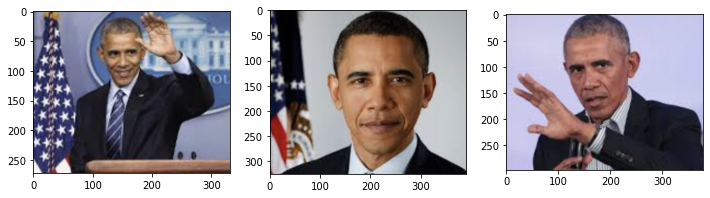

Do you know this person? yes
What is the person's name: Barack
Saving Barack as a known...
/tmp/s3bucket/testdir/person6.png /tmp/s3bucket/knowns/barack.png
barack saved as known!!!


In [34]:
analyze = input("Would you like to analyze the unknowns: [Y/N] ")
if analyze.lower().strip() in ['y','yes']:
    person_list = [f for f in os.listdir(image_dir)]
    print("There are {} unknowns to analyze...".format(len(person_list)))
    embedding_dict = {}
    np_images = []
    for p in person_list:
        np_image = crop_face_from_image(p)
        if np_image is None:
            print("problem with {}".format(p))
            continue
        encoding = calculate_embedding_from_image(np_image)
        if encoding is None:
            print("encoding problem with {}".format(p))
            del np_image
            continue
        np_images.append(np_image)
        analyze_image(p, encoding, embedding_dict)
        
    for key, value in embedding_dict.items():
        if len(value[1]) > 1:
            count = len(value[1])
            fig=plt.figure(figsize=(12, 12))
            columns = 3
            rows = int(np.ceil(count/columns))
            for i in range(0, count):
                image_path = image_dir + value[1][i]
                np_frame = cv2.imread(image_path)
                np_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)       
                fig.add_subplot(rows, columns, i+1)
                plt.imshow(np_frame)
            plt.show()
            known = input("Do you know this person? ")
            if known.lower().strip() in ['y','yes']:
                name = input("What is the person's name: ")
                print("Saving {} as a known...".format(name))
                save_dir = '/tmp/s3bucket/knowns/'
                name = name.lower().strip()
                src_path = image_dir + value[1][0]
                dst_path = save_dir + name + '.png'
                #print(src_path, dst_path)
                copyfile(src_path, dst_path)
                print("{} saved as known!!!".format(name))
            else:
                print("Person unknown, skipping ")